# Tutorial of Modified SINDy Using Lorenz Attractor as an Example

#### Example code for paper: [Automatic Differentiation to Simultaneously Identify Nonlinear Dynamics and Extract Noise Probability Distributions from Data, 2020, Kadierdan Kaheman, Steven L. Brunton, J. Nathan Kutz](https://arxiv.org/abs/2009.08810).

#### This file is the implementation of modified SINDy by using Julia Flux. For Python version using TensorFlow, please check our [GitHub page](https://github.com/dynamicslab/modified-SINDy).


Coded By: K Kahirman\
Last Updated: Oct 16th, 2020

# To start with, let's load some packages in order to perform automatic differentiation.

Flux is needed to perform the training. We use Julia 1.5.0 along with Flux v0.11.1 and CUDA v1.3.2.

In [118]:
using Flux 
using Flux: @epochs
using LinearAlgebra
using DifferentialEquations
using Plots
using LaTeXStrings
using CUDA
using Statistics
using Random
using Distributions

# Let's define the ODE of Lorenz attractor and get the simulation data.

The ODE of the Lorenz aatractor can be written as


$$\begin{equation}
    \begin{aligned}
        \dot{x}&=\sigma(y-x),\\
        \dot{y}&=x(\rho-z)-y,\\
        \dot{z}&=xy-\beta z,
    \end{aligned}
\end{equation}$$


where $\sigma=10$, $\rho=28$ and $\beta=\frac{8}{3}$. We define the state vector as $u=[x\ y\ z]^T$.

In [119]:
function Lorenz(du, u, p, t)
   #  p: Parameter vector.
   # du: Derivative of the system (left-hand side).
   #  u: State of the system.
   #  t: Time index.
   # return du: Derivative of system.
   #--------------------------- 
   du[1] = p[1]*(u[2]-u[1])
   du[2] = u[1]*(p[2]-u[3])-u[2]
   du[3] = u[1]*u[2]-p[3]*u[3] 
    
   return du
    
end

Lorenz (generic function with 1 method)

We simulate the Lorenz attractor with stime step $dt=0.01$ and time horizon $tspan=0:dt:25$ to generate the clean data. The initial condition is chosen as $u_0=[5;5;25]$.

In [120]:
# Define time step
dt=0.01

# Define final time
T1=25

# Define time horizon
tspan1=(0.0,T1)

# Define initial condition
u0=[5.0;5.0;25.0]

# Define parameters for simulating the 
p0=[10.0;28.0;8/3]

# Define the ODE problem
prob = ODEProblem(Lorenz,u0,tspan1,p0)

# Solve the ODE problem and get the clean data 
u=transpose(Array(solve(prob,saveat=dt)));

Once the clean data is generated, we can add Guassian noise to it and generate noisy measurement data. The noise level of the signal is define as:

$$\text { Noise Level }(\%)=\frac{\operatorname{var}(\text { Noise })}{\operatorname{var}(\text { Signal })} \times 100 \%.$$

In this tutorial let's pick noise level as $30\%$.

In [121]:
# Define noise level
NoiseLevel=20

# Define the random seed
Random.seed!(0)

# Calculate noise magnitude
NoiseMag=NoiseLevel*std(u,dims=1)/100

# Generate noise
Noise=NoiseMag.*randn(size(u))

# Now, add the noise to the clean data to generate the noisy measurment data
un=u+Noise;

If the derivative is not measured, such as we did in this example, it is necessary to approximate the derivative of noisy data using finite difference or other derivative approximation algorithm. 

In this tutorial, we use 5 points central difference to approximate the first order derivative of the noisy signal. The equation that approxiamtes the derivative can be written as:


$$\begin{equation}
    \dot{x}(t)=\frac{c_1x(t-2)+c_2x(t-1)+c_3x(t)+c_4x(t+1)+c_5x(t+2)}{12},
    \end{equation}$$
where $c_1=1$, $c_2=-8$, $c_3=0$, $c_4=8$, and $c_5=-1$. 

Moreover, we discard the first and last two data points. Thus, the total length of the new data vector is original data minus four.

In [122]:
function CalDerivative(u,dt)
    #  u: Measurement data we wish to approxiamte the derivative. 
    #  It should be of size n x m, where n is the number of measurement, m is the number of states.
    # dt: Time step
    # return du: The approximated derivative. 
    #--------------------------- 
    # First, get the information of the data length.
    len=size(u,1);
    n=size(u,2)
    
    # Define the coeficient for different orders of derivative
    p1=1/12;p2=-2/3;p3=0;p4=2/3;p5=-1/12;
    
    du=(p1*u[1:end-4,:]+p2*u[2:end-3,:]+p3*u[3:end-2,:]+p4*u[4:end-1,:]+p5*u[5:end,:])/dt;
        
    return du
end

CalDerivative (generic function with 1 method)

In [123]:
# Calculate the derivative
du=zeros(size(u))

# Calculate ground truth for derivative
for i=1:size(u,1)
    du[i,:]=Lorenz(zeros(1,3), u[i,:], p0, 0)
end
du=du[3:end-2,:]

dun=CalDerivative(un,dt)

# Discard the first and last two points
un=un[3:end-2,:];
Noise=Noise[3:end-2,:];

Plot the true state (clean data) and noisy data we will provide to the modified SINDy.

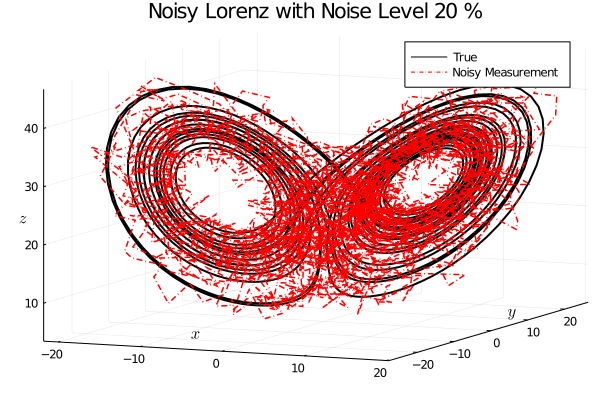

In [124]:
pp1=plot(u[:,1],u[:,2],u[:,3],lw=2,ls=:solid,linecolor="black",xlabel=L"x",ylabel=L"y",zlabel=L"z",title="Noisy Lorenz with Noise Level $(NoiseLevel) %",label="True")
pp1=plot!(un[:,1],un[:,2],un[:,3],lw=1.5,ls=:dashdot,linecolor="red",label="Noisy Measurement",camera = (30, 30))

# Define the libray for sparse regression 

Just like all other variation of SINDy like algorithm, we need to define the library matrix in order to identify the nonlinear equation that governs our data. In this example, we construct our library as:


$$\begin{equation}
    \Theta(x,y,z)=[x\ y\ z\ xy\ xz\ yz\ x^2\ y^2\ z^2].
    \end{equation}$$

In [125]:
function Lib(u)
    # u: The measuremt state matrix with size n x m, where n is the data length, m is the number of states. 
    # return Θ: Library matrix, with size of n x p, where p is the number of candidate terms in the library. 
    #---------------------------
    Θ=[u[:,1] u[:,2] u[:,3] u[:,1].*u[:,2] u[:,1].*u[:,3] u[:,2].*u[:,3] u[:,1].^2 u[:,2].^2 u[:,3].^2]
    
    return Θ
    
end

Lib (generic function with 1 method)

Once our library is defined, we can define the right-hand side of our ODE as:


$$\begin{equation}
        \dot{u}=f(u)=Θ\left(u\right)\Xi,
    \end{equation}$$


where $\Xi \in R^{p\times m}$, and $p$ is the number of candidate terms in the library, $m$ is the number of state variables. In this example, $p=9$ and $m=3$. Moreover, notice if


$$\begin{equation}
\Xi=\begin{bmatrix}
    -10 & 28 & 0\\
     10 & -1 & 0\\
      0 &  0 & -\frac{8}{3}\\
      0 &  0 & 1\\
      0 & -1 & 0 \\
      0 &  0 & 0\\
      0 &  0 & 0\\
      0 &  0 & 0\\
      0 &  0 & 0\\
\end{bmatrix}
\end{equation},$$


$Θ\left(u\right)\Xi$ will yeild the correct model of Lorenz equation we wish to identify.

In [126]:
function ODE_RHS(u,Ξ)
   # u: The measuremt state matrix with size n x m, where n is the data length, m is the number of states. 
   # Ξ: Selection matrix with size p x m, where p is the number of candidate terms in the library, m is the number of state variables. 
   #--------------------------- 
   du=Lib(u)*Ξ
    
   return du
    
end

ODE_RHS (generic function with 1 method)

After we defined what our ODE right-hand side looks like, which is:

$$\begin{equation}
        \dot{u}=f(u)=Θ\left(u\right)\Xi,
    \end{equation}$$
    
we can simulate this estimate of our dynamics forward and backward using 4th order Runge-Kutta method. In other words, given selection parameter $\Xi$, library $\Theta$, and current system state $u(t)$, we can estimate $u(t+1)$ using:

$$\begin{equation}
        \hat{u}(t+1)\approx u(t)+\frac{1}{6}(K_{f1}+2K_{f2}+2K_{f3}+K_{f4})dt,
    \end{equation}$$
where
$$\begin{equation}
  \begin{aligned}
      K_{f1}&=\Theta(u(t))\Xi,\\
      K_{f2}&=\Theta(u(t)+\frac{K_{f1}}{2}dt)\Xi,\\
      K_{f3}&=\Theta(u(t)+\frac{K_{f2}}{2}dt)\Xi,\\
      K_{f4}&=\Theta(u(t)+K_{f3}dt)\Xi.
  \end{aligned}
\end{equation}$$

Similarly, we can estimate $q$ steps forward in time and have:

$$\begin{equation}
        \hat{u}(t+q)\approx RK45(u(t),q),
    \end{equation}$$

where $RK45(u(t),q)$ represents simulating the system dynamics forward for $q$ steps. 

We can also estimate $u(t-1)$ by

$$\begin{equation}
        \hat{u}(t-1)\approx u(t)-\frac{1}{6}(K_{b1}+2K_{b2}+2K_{b3}+K_{b4})dt,
    \end{equation}$$
where
$$\begin{equation}
  \begin{aligned}
      K_{b1}&=\Theta(u(t))\Xi,\\
      K_{b2}&=\Theta(u(t)-\frac{K_{b1}}{2}dt)\Xi,\\
      K_{b3}&=\Theta(u(t)-\frac{K_{b2}}{2}dt)\Xi,\\
      K_{b4}&=\Theta(u(t)-K_{b3}dt)\Xi.
  \end{aligned}
\end{equation}$$

For more details on the RK45 method, please check this [Wiki page](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods).

In [127]:
function RK_45_Forward(u,Ξ,dt)
    # u: The measuremt state matrix with size n x m, where n is the data length, m is the number of states. 
    # Ξ: Selection matrix with size p x m, where p is the number of candidate terms in the library, m is the number of state variables.
    # dt: Time step.
    # return ues: Estimate future state.
    #---------------------------
    Kf1=ODE_RHS(u,Ξ)*dt

    dum1=u+0.5*Kf1
    Kf2=ODE_RHS(dum1,Ξ)*dt

    dum2=u+0.5*Kf2
    Kf3=ODE_RHS(dum2,Ξ)*dt

    dum3=u+Kf3
    Kf4=ODE_RHS(dum3,Ξ)*dt
    #
    ues=u.+(1/6)*(Kf1.+2*Kf2.+2*Kf3.+Kf4)
    
    return ues
end

RK_45_Forward (generic function with 1 method)

In [128]:
function RK_45_Backward(u,Ξ,dt)
    # u: The measuremt state matrix with size n x m, where n is the data length, m is the number of states. 
    # Ξ: Selection matrix with size p x m, where p is the number of candidate terms in the library, m is the number of state variables.
    # q: backward step.
    # dt: Time step.
    # return ues: Estimate past state.
    #---------------------------
    Kb1=ODE_RHS(u,Ξ)*dt

    dum1=u-0.5*Kb1
    Kb2=ODE_RHS(dum1,Ξ)*dt

    dum2=u-0.5*Kb2
    Kb3=ODE_RHS(dum2,Ξ)*dt

    dum3=u-Kb3
    Kb4=ODE_RHS(dum3,Ξ)*dt
    #
    ues=u.-(1/6)*(Kb1.+2*Kb2.+2*Kb3.+Kb4)

    return ues
end

RK_45_Backward (generic function with 1 method)

# Identification result using original SINDy algorithm

To make a comparison between the original SINDy and modified SINDy, let's first provide the noisy derivative and noisy measurement to the original SINDy algorithm. 

For more details about the original SINDy algorithm, please see paper ["Discovering governing equations from data by sparse identification of nonlinear dynamical systems" by Brunton et al](https://www.pnas.org/content/113/15/3932). 

In [129]:
function sparsify(Θ,du,λ,iter)
    # Θ: The library matrix with size n x p, where n is the data length, p is the number of nonlinear basis. 
    # du: Estimated or measured derivative of dynamics.
    # λ: Thresholding parameter.
    # iter: Number of regressions you would like to perform.
    # return ues: Estimate past state.
    #---------------------------
    # First get the number of states
    n_state=size(du,2)
    
    # Next, perform regression, get an estimate of the selection matrix Ξes 
    Ξes=Θ\du
    
    for i=1:iter
        # Get the index of values whose absolute value is smaller than λ
        smallinds = (abs.(Ξes).<λ)
        
        # Set the parameter value of library term whose absolute value is smaller than λ as zero
        Ξes[smallinds].=0;
        
        # Regress the dynamics to the remaining terms
        for ind=1:n_state
            biginds = .!smallinds[:,ind]
            Ξes[biginds,ind] = Θ[:,biginds]\du[:,ind]
        end
    end

    return Ξes
    
end

sparsify (generic function with 1 method)

##### Estimate the system dynamics using original SINDy algorithm

In [131]:
# Define the number of sparse regressions you would like to perform.
iter=10

# Define the sparsity parameter
λs=0.2

# Get the library matrix
Θs=Lib(un)

# Estimate the selection matrix using SINDy
println("The sparse slection matrix identified by original SINDy using sparsity thresholding parameter $(λs) is:\n")
Ξes_sindy=sparsify(Θs,dun,λs,iter)

The sparse slection matrix identified by original SINDy using sparsity thresholding parameter 0.2 is:



9×3 Array{Float64,2}:
 -7.46043  12.202     -0.734075
  7.71237   7.92308    0.574023
  0.0       0.0       -2.52433
  0.0       0.0        0.966027
  0.0      -0.547511   0.0
  0.0      -0.247396   0.0
  0.0       0.0        0.0
  0.0       0.0        0.0
  0.0       0.0        0.0

### Conclusion:

#### We can see from the above example that the original SINDy algorithm will fail to identify the correct model of Lorenz attractor under such high noise regime. 

#### Moreover, the estimated parameters of term that do exist in the true dynamic are quite off from the true one.

#### Thus, we developed the modified SINDy algorithm, which utilize the noise signal separation idea purposed by [Rudy et al](https://www.sciencedirect.com/science/article/pii/S0021999119304644). By considering the effect of noise into the sparse regression algorithm, we can greatly increase the robustness of SINDy algorithm.

# Results of using modified SINDy algorithm

#### The overall idea of modified SINDy can be summerized into following figure.
<p align="center">
<img src="Images\Method.png" width="600">
</p>

What we are trying to do in the above figure is setting the noise at each time step as an optimization parameter. Thus, if we minus the estimated future/past noise from the future/past noisy measurement, what we will have is the estimated future/past state. If we simulate those estimated state forward/backward in time, we will again have future/past state estimate, and we are trying to minimizing the difference of two.

Moreover, to further constraint the dynamics and obtain a better estimate of derivative, we also minimize the difference of left-hand side and right-hand side (denoted as $\|\dot{\hat{{\mathbf{X}}}}-\mathbf{\Theta}({\hat{\mathbf{X}}})\Xi\|_2^2$). For more details, please check out our [paper](https://arxiv.org/abs/2009.08810).

The algorithm of modified SINDy can be summarized into following figure.

<p align="center">
<img src="Images\Algorithm.png" width="600">
</p>

### Define the loss function

In [132]:
# Turn off the GPU allegation to speed up
CUDA.allowscalar(false)

function loss(Measurement,NoiseEs,Ξes,Ξactive,q,dt,ω)
    # Measurement: Measurment matrix with size of n x m, where n is the data length and m is the number state variables.
    # NoiseEs: Estimate of noise added to signal.
    # Ξes: Estimated selection vector.
    # Ξactive: Activation matrix. If the elements in Ξactive is zero, then it means the correpsonding basis in the library is set to inactive.
    # q: Forward/backward simulation step.
    # dt: Time step.
    # ω: Decaying factor of loss value.
    # return LossVal: Value of loss function.
    #--------------------------- 
    # The selection vector that defines our ODE's right hand side should exclude the inactive nonlinear terms
    Ξdummy=Ξes.*Ξactive
    
    # Define matrix to store value
    FutureEstimate=[]
    PastEstimate=[]
    lossFuture=0
    lossPast=0
    lossEstimate=0
    
    # Simulate system based on intial conditions
    for i=1:q
        # If this is the first prediction
        if i==1
            # Estimate the future state, the initial condition's index ranges from t=1 to t=n-q, thus the estimated states'
            # index will range from t=2 to t=n-q+1
            FutureEstimate=RK_45_Forward(Measurement[1:end-q,:]-NoiseEs[1:end-q,:],Ξdummy,dt)
            
            # Estimate the past state, the initial condition's index ranges from t=q+1 to t=n, thus the estimated states'
            # index will range from t=q to t=n-1
            PastEstimate=RK_45_Backward(Measurement[q+1:end,:]-NoiseEs[q+1:end,:],Ξdummy,dt)
            
            # Calculate the future estimate loss
            lossFuture=norm(Measurement[1+i:end-q+i,:]-NoiseEs[1+i:end-q+i,:]-FutureEstimate).^2
            
            # Calculate the past estimate loss
            lossPast=norm(Measurement[q+1-i:end-i,:]-NoiseEs[q+1-i:end-i,:]-PastEstimate).^2
            
            # Add future and past loss together
            lossEstimate=(ω^(i-1))*(lossFuture+lossPast)
        else
            # Again estimate the future state one step forward based on previous simulated state value
            # The estimated states' index will range from t=1+i to t=n-q+i this time.
            FutureEstimate=RK_45_Forward(FutureEstimate,Ξdummy,dt) 

            # Similarly, estimate the past state one step backward based on previous simulated state
            # The estimated states' index will range from t=q+1-i to t=n-i this time.
            PastEstimate=RK_45_Backward(PastEstimate,Ξdummy,dt) 

            # Calculate the future estimate loss
            lossFuture=norm(Measurement[1+i:end-q+i,:]-NoiseEs[1+i:end-q+i,:]-FutureEstimate).^2
            
            # Calculate the past estimate loss
            lossPast=norm(Measurement[q+1-i:end-i,:]-NoiseEs[q+1-i:end-i,:]-PastEstimate).^2
            
            # Add future and past loss together
            lossEstimate=lossEstimate+(ω^(i-1))*(lossFuture+lossPast)
        end
    end
            
    # After calculated the simulation error, calculate the derivative error
    #Calculate the numerical derivative on the estimated true state to get the approximation of true derivative
    EstimatedDerivative_LHS=CalDerivative(Measurement-NoiseEs,dt)
    
    #Calculate the derivative estimate by ODE right hand side
    EstimatedDerivative_RHS=Lib(Measurement[3:end-2,:]-NoiseEs[3:end-2,:])*Ξdummy
    
    #Calculate the loss of two derivative estimates
    lossDerivative=norm(EstimatedDerivative_LHS-EstimatedDerivative_RHS).^2
    
    # Finally, add all the loss together
    lossVal=lossEstimate+lossDerivative
    
    return lossVal
    
end


loss (generic function with 1 method)

### Define training function

In [133]:
function trainLoss(Measurement,NoiseEs,Ξes,Ξactive,q,dt,ω,Ntrain,θ,opt)
    # Measurement: Measurment matrix with size of n x m, where n is the data length and m is the number state variables.
    # NoiseEs: Estimate of noise added to signal.
    # Ξes: Estimated selection vector.
    # Ξactive: Activation matrix. If the elements in Ξactive is zero, then it means the correpsonding basis in the library is set to inactive.
    # q: Forward/backward simulation step.
    # dt: Time step.
    # ω: Decaying factor of loss value.
    # Ntrain: Iteration of the optimizer.
    # θ: Optimization variable
    # opt: Optimizer.
    # return: none
    #--------------------------- 
    for i=1:Ntrain
        # Get the gradient of loss function
        grads=gradient(()->loss(Measurement,NoiseEs,Ξes,Ξactive,q,dt,ω),θ)
        
        # Update the optimization variable
        for p in θ
            Flux.Optimise.update!(opt, p, grads[p])
        end
        
        # Print training process
        if mod(i,Int(floor(Ntrain/10)))==0
            println("\t $((i/(Ntrain/10))*10) percent finished...Current cost value is $(loss(Measurement,NoiseEs,Ξes,Ξactive,q,dt,ω))")
        end
    end
        
end

trainLoss (generic function with 1 method)

### Define modified SINDy

In [134]:
function modified_SINDy(Measurement,q,dt,ω,λms,iter,Nloop,Ntrain,opt,c_or_g)
    # Measurement: Measurment matrix with size of n x m, where n is the data length and m is the number state variables.
    # q: Forward/backward simulation step.
    # dt: Time step.
    # ω: Decaying factor of loss value.
    # λms: Thresholding parameter for modified SINDy.
    # iter: Regression iteration of SINDy algorithm.
    # Nloop: Number of optimization loop.
    # Ntrain: Iteration of the optimizer.
    # opt: Optimizer.
    # c_or_g: Choose wether to use GPU, available input: cpu, gpu
    # return: NoiseEs: Estimated noise. Ξes: Estimated parameters of nonlinear basis
    #---------------------------              
    # First estimate the noise, here we do not use any pre-smoothing and set the initial estimate of noise as zeros
    NoiseEs=zeros(size(Measurement))
    
    # After estimating the noise, we can estimate the true state by subtracting estimated noise from measurement
    StateEs0=Measurement-NoiseEs
    
    # Get the number of states
    n_state=size(Measurement,2)
    
    # Based on the estimated state, we can estimate the derivative of the state
    StateDerivativeEs=CalDerivative(StateEs0,dt)

    # Once we get the estimated state and its corresponding derivative, we can estimate the value of Ξes
    Θms=Lib(StateEs0[3:end-2,:])
    Ξes=sparsify(Θms,StateDerivativeEs,λms,iter)
    
    # When first started, set the activation matrix as ones
    Ξactive=ones(size(Ξes))
    
    # Now transfer the data to cpu or gpu
    if c_or_g==gpu
        Measurement=CuArray(Measurement)
        NoiseEs=CuArray(NoiseEs)
        Ξes=CuArray(Ξes)
        Ξactive=CuArray(Ξactive)
    end
    
    # Now start training loop
    for j=1:Nloop
        # Define optimization variables we would like to train
        θ=Flux.params([NoiseEs,Ξes])
        
        println("Loop $(j)...")
        
        # Training statrt!
        trainLoss(Measurement,NoiseEs,Ξes,Ξactive,q,dt,ω,Ntrain,θ,opt)
        
        println("Loop $(j) finished!")
        
        # Get the index of basis whose parameter is larger than threshold
        biginds=abs.(Ξes).>λms
        
        # Update the activation matrix
        if c_or_g==gpu
            Ξactive=Ξactive.*(CuArray((Int.(biginds))))
        else
            Ξactive=Ξactive.*((Int.(biginds)))
        end
        
        # Set the paramters of basis whose value smaller than threshold as zero, reassign this value to a 
        # dummy variable to store the value.
        Ξ=(Ξes.*Ξactive)|>cpu
        
        # Get the new estimate of state, and transfer this to cpu
        # Note: Here we discarded first and last q points since those point are only 
        # constrained using forward or backward dynamics, and not the both.
        StateEs=(Measurement[q+1:end-q-1,:]-NoiseEs[q+1:end-q-1,:])|>cpu
        
        # Transfer the big index to cpu
        biginds=biginds|>cpu
        
        # Bsed on the updated state estimate, calculate the estimated derivative
        StateDerivativeEs=CalDerivative(StateEs,dt)
        
        # Get the new library matrix based on updated state estimate 
        Θms=Lib(StateEs[3:end-2,:])
        
        # Regress on the terms that is active
        for ind=1:n_state
            Ξ[biginds[:,ind],ind] = Θms[:,biginds[:,ind]]\StateDerivativeEs[:,ind]
        end
        
        # Reassign the Ξes as optimization variable using the value stored in Ξ
        if c_or_g==gpu
            Ξes=CuArray(Ξ)
        else
            Ξes=Ξ
        end
        
        # Display the new parameter matrix
        println("Current value of the Ξ is shown above...\n")
        display(Ξes)
    end
    
    return NoiseEs|>cpu,Ξes|>cpu
end

modified_SINDy (generic function with 1 method)

### Define parameters for modified SINDy

In [136]:
# Define prediction step, here we use q=2
q=1

# Define decay factor 
ω=0.9

# Define iteration of optimizer
Ntrain=5000

# Define sparse regression loop
Nloop=6

# Define optimizer
opt = ADAM()
    
# Define whether to GPU for training, available option: cpu or gpu
c_or_g=gpu

# Define thresholding parameter
λms=0.1

# Define the number of sparse regressions you would like to perform at the begining
iter=10;

### Finally, train it!

In [137]:
@time EstimatedNoise,EstimateΞ=modified_SINDy(un,q,dt,ω,λms,iter,Nloop,Ntrain,opt,c_or_g);

Loop 1...
	 10.0 percent finished...Current cost value is 1.0557040407196282e8
	 20.0 percent finished...Current cost value is 5.966165210693124e7
	 30.0 percent finished...Current cost value is 3.3922802731438436e7
	 40.0 percent finished...Current cost value is 1.9390886865287766e7
	 50.0 percent finished...Current cost value is 1.1172522043034159e7
	 60.0 percent finished...Current cost value is 6.52029687980776e6
	 70.0 percent finished...Current cost value is 3.878803967595522e6
	 80.0 percent finished...Current cost value is 2.3671674591622585e6
	 90.0 percent finished...Current cost value is 1.4894428109122145e6


9×3 CuArray{Float64,2}:
 -3.50029    22.1984     -0.0741171
  5.21043     2.7981      0.153143
 -0.105589    0.0403387  -2.63378
 -0.0175994   0.0125457   1.01972
 -0.187106   -0.832434    0.0
  0.145176   -0.111221    0.0
  0.0386584  -0.0109018  -0.0130096
  0.0        -0.0        -0.0
 -0.0         0.0         0.0

	 100.0 percent finished...Current cost value is 968417.8066566129
Loop 1 finished!
Current value of the Ξ is shown above...

Loop 2...
	 10.0 percent finished...Current cost value is 633610.852596952
	 20.0 percent finished...Current cost value is 427603.54508277145
	 30.0 percent finished...Current cost value is 291828.1045328264
	 40.0 percent finished...Current cost value is 198727.77016418657
	 50.0 percent finished...Current cost value is 133736.8596772414
	 60.0 percent finished...Current cost value is 88560.32148178467
	 70.0 percent finished...Current cost value is 57768.35369843063
	 80.0 percent finished...Current cost value is 37299.1823393929
	 90.0 percent finished...Current cost value is 24026.699329410443


9×3 CuArray{Float64,2}:
 -8.92361    27.8135    -0.0
  9.58916    -0.823874   0.212031
 -0.0197574   0.0       -2.64409
 -0.0         0.0        0.99881
 -0.0236705  -0.997832   0.0
  0.0        -0.0        0.0
  0.0        -0.0        0.0
  0.0        -0.0       -0.0
 -0.0         0.0        0.0

	 100.0 percent finished...Current cost value is 15604.225205214414
Loop 2 finished!
Current value of the Ξ is shown above...

Loop 3...
	 10.0 percent finished...Current cost value is 12939.995065736246
	 20.0 percent finished...Current cost value is 7664.465860400907
	 30.0 percent finished...Current cost value is 4888.449604469734
	 40.0 percent finished...Current cost value is 3185.093062038023
	 50.0 percent finished...Current cost value is 2088.6381194482983
	 60.0 percent finished...Current cost value is 1362.8501343136688
	 70.0 percent finished...Current cost value is 879.9700162412687
	 80.0 percent finished...Current cost value is 560.9162241728839
	 90.0 percent finished...Current cost value is 354.4370423676521


9×3 CuArray{Float64,2}:
 -9.95476  27.7819    -0.0
  9.87702  -0.792793   0.0
  0.0       0.0       -2.64248
 -0.0       0.0        0.996609
 -0.0      -0.997611   0.0
  0.0      -0.0        0.0
  0.0      -0.0        0.0
  0.0      -0.0       -0.0
 -0.0       0.0        0.0

	 100.0 percent finished...Current cost value is 225.7388438768451
Loop 3 finished!
Current value of the Ξ is shown above...

Loop 4...
	 10.0 percent finished...Current cost value is 173.28696018645482
	 20.0 percent finished...Current cost value is 107.47819742884619
	 30.0 percent finished...Current cost value is 73.51107338208591
	 40.0 percent finished...Current cost value is 53.29264555472126
	 50.0 percent finished...Current cost value is 39.683720378903736
	 60.0 percent finished...Current cost value is 29.691043583291705
	 70.0 percent finished...Current cost value is 22.251180560033163
	 80.0 percent finished...Current cost value is 16.38610164631027
	 90.0 percent finished...Current cost value is 12.173561260937467

9×3 CuArray{Float64,2}:
 -10.0429   27.9258    -0.0
   9.98733  -0.940662   0.0
   0.0       0.0       -2.66769
  -0.0       0.0        1.00678
  -0.0      -0.995606   0.0
   0.0      -0.0        0.0
   0.0      -0.0        0.0
   0.0      -0.0       -0.0
  -0.0       0.0        0.0


	 100.0 percent finished...Current cost value is 9.157880693914692
Loop 4 finished!
Current value of the Ξ is shown above...

Loop 5...
	 10.0 percent finished...Current cost value is 7.052463125075963
	 20.0 percent finished...Current cost value is 5.456015546306512
	 30.0 percent finished...Current cost value is 4.225538524439306
	 40.0 percent finished...Current cost value is 3.33082963516698
	 50.0 percent finished...Current cost value is 2.5928061142631185
	 60.0 percent finished...Current cost value is 2.110531473454948
	 70.0 percent finished...Current cost value is 1.7500623060534661
	 80.0 percent finished...Current cost value is 1.4791186682813129
	 90.0 percent finished...Current cost value is 1.2484925757008332


9×3 CuArray{Float64,2}:
 -10.0471  27.9487    -0.0
  10.009   -0.956333   0.0
   0.0      0.0       -2.66609
  -0.0      0.0        1.00622
  -0.0     -0.995791   0.0
   0.0     -0.0        0.0
   0.0     -0.0        0.0
   0.0     -0.0       -0.0
  -0.0      0.0        0.0

	 100.0 percent finished...Current cost value is 1.150669933636256
Loop 5 finished!
Current value of the Ξ is shown above...

Loop 6...
	 10.0 percent finished...Current cost value is 1.0228333036330168
	 20.0 percent finished...Current cost value is 0.91983535431872
	 30.0 percent finished...Current cost value is 0.8455838792490611
	 40.0 percent finished...Current cost value is 4.293565218393071
	 50.0 percent finished...Current cost value is 0.7664885772031435
	 60.0 percent finished...Current cost value is 0.7422068045790756
	 70.0 percent finished...Current cost value is 0.6504271757389593
	 80.0 percent finished...Current cost value is 0.6608978590201143
	 90.0 percent finished...Current cost value is 0.6383588428248627


9×3 CuArray{Float64,2}:
 -10.0462  27.9607    -0.0
  10.0167  -0.963713   0.0
   0.0      0.0       -2.66519
  -0.0      0.0        1.00597
  -0.0     -0.995921   0.0
   0.0     -0.0        0.0
   0.0     -0.0        0.0
   0.0     -0.0       -0.0
  -0.0      0.0        0.0

	 100.0 percent finished...Current cost value is 0.5838076316151962
Loop 6 finished!
Current value of the Ξ is shown above...

300.719995 seconds (1.15 G allocations: 30.258 GiB, 3.31% gc time)


The true parameter we are looking for is:

$$\begin{equation}
\Xi=\begin{bmatrix}
    -10 & 28 & 0\\
     10 & -1 & 0\\
      0 &  0 & -\frac{8}{3}\\
      0 &  0 & 1\\
      0 & -1 & 0 \\
      0 &  0 & 0\\
      0 &  0 & 0\\
      0 &  0 & 0\\
      0 &  0 & 0\\
\end{bmatrix}
\end{equation},$$

### Plot the denoised signal

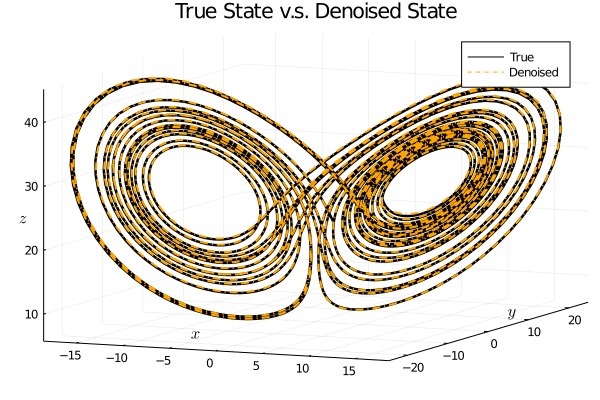

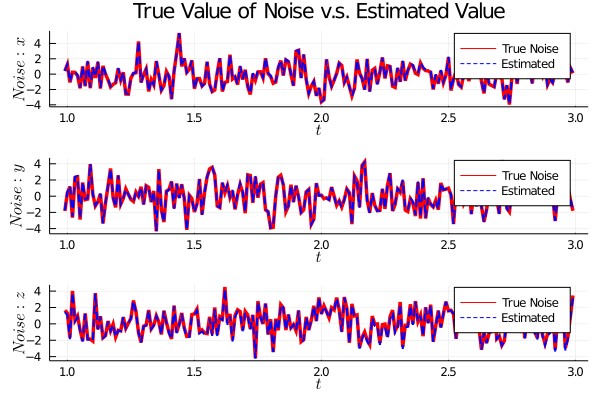

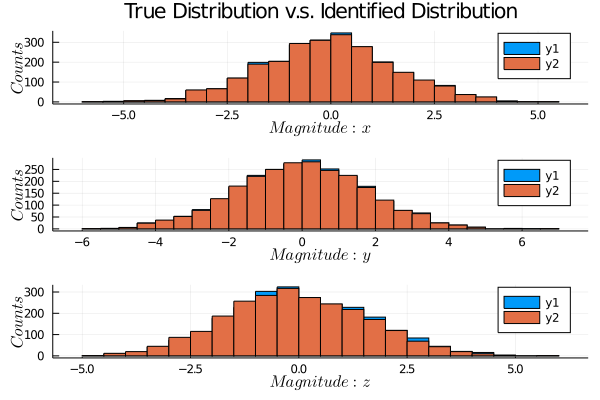

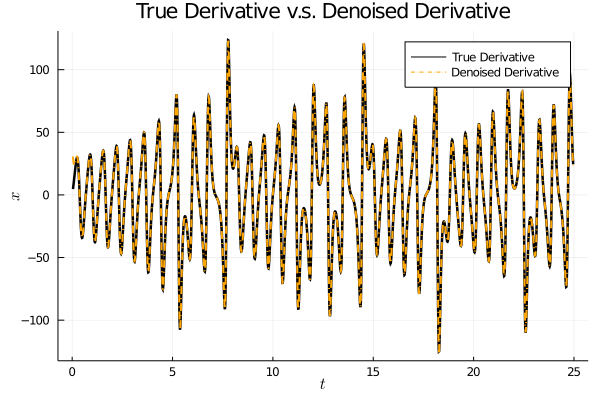

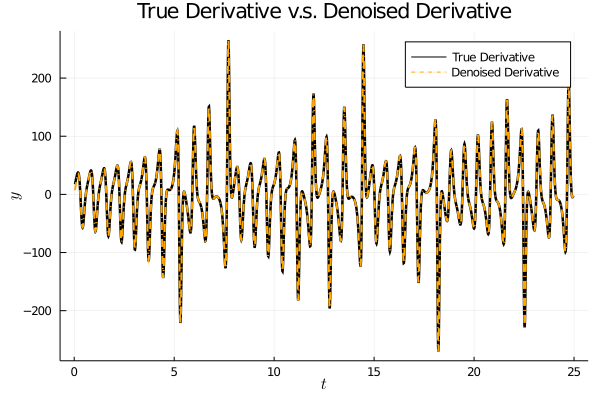

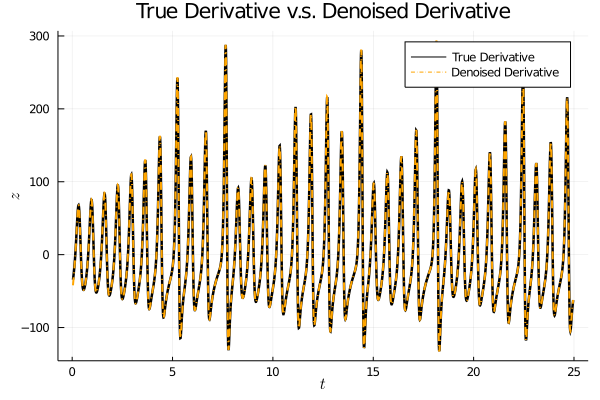

In [138]:
# Get the estimated satte
ues=un-EstimatedNoise
dues=CalDerivative(ues,dt)

# Define start and end index for plotting the noise
StartInd=100
EndInd=300

# Get time index
Time=collect(0:dt:T1)

pp1=plot(u[:,1],u[:,2],u[:,3],lw=2.5,ls=:solid,linecolor="black",
    xlabel=L"x",ylabel=L"y",zlabel=L"z",title="True State v.s. Denoised State",label="True")
pp1=plot!(ues[:,1],ues[:,2],ues[:,3],lw=2.0,ls=:dashdot,linecolor="orange",label="Denoised",camera = (30, 30))

pp2=plot(Time[StartInd:EndInd,1],Noise[StartInd:EndInd,1],xlabel=L"t",
    ylabel=L"Noise: x",label="True Noise",color="red",lw=3.5,title="True Value of Noise v.s. Estimated Value")
pp2=plot!(Time[StartInd:EndInd,1],EstimatedNoise[StartInd:EndInd,1],label="Estimated",color="blue",ls=:dash,lw=2)

pp3=plot(Time[StartInd:EndInd,1],Noise[StartInd:EndInd,2],
    xlabel=L"t",ylabel=L"Noise: y",label="True Noise",color="red",lw=3.5)
pp3=plot!(Time[StartInd:EndInd,1],EstimatedNoise[StartInd:EndInd,2],label="Estimated",color="blue",ls=:dash,lw=2)

pp4=plot(Time[StartInd:EndInd,1],Noise[StartInd:EndInd,3],
    xlabel=L"t",ylabel=L"Noise: z",label="True Noise",color="red",lw=3.5)
pp4=plot!(Time[StartInd:EndInd,1],EstimatedNoise[StartInd:EndInd,3],label="Estimated",color="blue",ls=:dash,lw=2)

pp5=plot(pp2,pp3,pp4,layout=(3,1))

pp6=histogram(Noise[:,1], bins=:scott,
    xlabel=L"Magnitude: x",ylabel=L"Counts",title="True Distribution v.s. Identified Distribution")
pp6=histogram!(EstimatedNoise[:,1], bins=:scott)

pp7=histogram(Noise[:,2], bins=:scott,xlabel=L"Magnitude: y",ylabel=L"Counts")
pp7=histogram!(EstimatedNoise[:,2], bins=:scott)

pp8=histogram(Noise[:,3], bins=:scott,xlabel=L"Magnitude: z",ylabel=L"Counts")
pp8=histogram!(EstimatedNoise[:,3], bins=:scott)

pp9=plot(pp6,pp7,pp8,layout=(3,1))

pp10=plot(Time[5:end-4,1],du[3:end-2,1],lw=2.5,ls=:solid,linecolor="black",
    xlabel=L"t",ylabel=L"x",title="True Derivative v.s. Denoised Derivative",label="True Derivative")
pp10=plot!(Time[5:end-4,1],dues[:,1],lw=2.0,ls=:dashdot,linecolor="orange",label="Denoised Derivative",camera = (30, 30))

pp11=plot(Time[5:end-4,1],du[3:end-2,2],lw=2.5,ls=:solid,linecolor="black",
    xlabel=L"t",ylabel=L"y",title="True Derivative v.s. Denoised Derivative",label="True Derivative")
pp11=plot!(Time[5:end-4,1],dues[:,2],lw=2.0,ls=:dashdot,linecolor="orange",label="Denoised Derivative",camera = (30, 30))

pp12=plot(Time[5:end-4,1],du[3:end-2,3],lw=2.5,ls=:solid,linecolor="black",
    xlabel=L"t",ylabel=L"z",title="True Derivative v.s. Denoised Derivative",label="True Derivative")
pp12=plot!(Time[5:end-4,1],dues[:,3],lw=2.0,ls=:dashdot,linecolor="orange",label="Denoised Derivative",camera = (30, 30))


display(pp1)
display(pp5)
display(pp9)
display(pp10)
display(pp11)
display(pp12)

# Try it yourself :)

Congratulations! You just finished the tutorial on how to implement modified SINDy! I hope you understood the fundamental idea behind it, and I hope it can help your research project. 

To help you further understand the algorithm, I prepared some questions for you, and I hope you can modify the code and try it out yourself.

- If you have a GPU, try using CPU and GPU to solve the optimization problem, and see how much speed up you can get using GPU.
- Try to use a higher noise level and see how modified SINDy performs (for example, 30%). You might need to tune the $\lambda_{ms}$, $q$, $N_{train}$ and $N_{loop}$ to generate the correct result (Try $\lambda_{ms}=0.1$, $q=1$, $N_{train}=5000$ and $N_{loop}=8$ when the random seed is set to 0 and noise level is 30%).
- When the noise level is too high, you might find out modified SINDy won't generate the correct result, and it will get stuck to the local minimum. Try to implement your favorite signal smoothing algorithm to get a better initial estimate of real noise (soft start). Then, see whether pre-smoothing will improve the highest noise level modified SINDy can handle.
- When the noise level is too high, using an iterative approach to gradually denosie the signal might help us identify the correct dynamics.
- In this notebook, try to use a different value of threshold $\lambda_{ms}$, and observe how the choice of $\lambda_{ms}$ will affect the final result.
- In this notebook, try to use a different value of $N_{loop}$, and observe how the choice of $N_{loop}$ will affect the final result.
- In this notebook, try to use a different value of prediction step $q$, and observe how the choice of $q$ will affect the final result. Moreover, examine what will happen to the run time of code if you use a large value of $q$ (for example, $q=4$). Will the code run faster or slower?
- In this notebook, try to use a larger library for modified SINDy (for example, up to polynomial order of 3). Observe what will happen to the run time of code.  Will the code run faster or slower? Moreover, at the same level of noise, compare modified SINDy performance when using a small library and large library. You might notice when using a more massive library, the $\lambda_{ms}$ needs to be carefully tuned to get the correct result.
- Instead of using Gaussian noise, try to add different noise types to the signal—for example, Uniform distribution noise, Dweibull distribution noise, or Gamma distribution noise. You can also generate custom noise distribution and see whether modified SINDy will identify it correctly.
- Guess what types of noise are more easier to identify. Zero-mean ones or non-zero-mean ones? What you think might help us identify non-zero-mean noise better?
- The idea of separating the noise from signal comes from the work of [Rudy et al](https://www.sciencedirect.com/science/article/pii/S0021999119304644), read that paper and think about when you should use neural network based noise signal speration approach and when you should use modified SINDy? 
- No algorithm works perfectly for all kinds of tasks. Sometimes a good research project starts by realizing what drawbacks the current approach has. Please name at least two disadvantages of modified SINDy and think about how you can improve it. 

With that, I hope you can appretiate the beauty of noise signal separation approach and I also wish it can help you for your research project! Thank you for reading!

(Most answers of the above questions can be found in our paper:  [Automatic Differentiation to Simultaneously Identify Nonlinear Dynamics and Extract Noise Probability Distributions from Data, 2020, Kadierdan Kaheman, Steven L. Brunton, J. Nathan Kutz](https://arxiv.org/abs/2009.08810)).